This file consits ESIM training model and test prediction script

The input file for training is: **'3_class_train_set.json'** which exists in current path

The input file for predicting test-unlabelled.json is **'3_class_test-unlabelled.json'** which is in current path

Finally the predicted file will be output as JSON file named **'testoutput.json'**

In [ ]:
"""
This code runs on Google Colaboratory with GPU runtime

Please upload relvent input files into google drive 
(Three files:'3_class_train.json', '3_class_test-unlabelled.json' and 'glove.6B.300d.txt')
glove.6B.300d.txt could be retrieved at http://nlp.stanford.edu/data/glove.6B.zip, 
and other two files are the output from previous step.
"""
from google.colab import drive
import os
drive.mount('/gdrive')

# Please modify DRIVE_FOLDER to the path where all output file and glove embedding file exists.
# in this situation, all files mentioned above are stored in '/gdrive/My Drive/glove.6B/'.
DRIVE_FOLDER = '/gdrive/My Drive/glove.6B/'

TRAIN_PATH = os.path.join(DRIVE_FOLDER, '3_class_train_set.json')
DEV_PATH = os.path.join(DRIVE_FOLDER, '3_class_devset.json')
UNLABEL_PATH = os.path.join(DRIVE_FOLDER, '3_class_test-unlabelled.json')
glove_path = os.path.join(DRIVE_FOLDER, 'glove.6B.300d.txt')

In [0]:
import nltk
import json
import numpy as np
import csv



import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.layers import LSTM, Input, Dot, Softmax, Multiply, Concatenate, Subtract, Dense, Lambda, Embedding, Dropout
from keras.layers import Bidirectional
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from pathlib import Path

In [0]:
MAX_NB_Words = 48000
Embedding_dim = 300
Max_seq_length = 100

In [0]:
def evidence_pre_processing(evidence):
    temp = ''
    for sentence in evidence:
        title, id = sentence.split()[0], sentence.split()[1]
        sentence = sentence.strip(title).lstrip(' ').strip(id).lstrip(' ').rstrip('\n')
        sentence = sentence.replace('-LRB-', '(').replace('-RRB-', ')').replace('-COLON-', ':')
        temp = temp + sentence
    return temp

In [0]:
def label_encoding(all_labels):
    temp = []
    for label in all_labels:
        if label == 'SUPPORTS':
            temp.append([1.0, 0.0, 0.0])
        elif label == 'REFUTES':
            temp.append([0.0, 1.0, 0.0])
        elif label == 'NOT ENOUGH INFO':
            temp.append([0.0, 0.0, 1.0])
    return temp

In [0]:
def read_file(file):
    all_claims = []
    all_evidences = []
    all_labels = []
    count = 0
    with open(file, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            label = value['label']
            evidence = evidence_pre_processing(value['evidence'])
            claim = value['claim']
            if len(evidence) <= 500 and len(claim) <= 500:
                all_claims.append(claim)
                all_evidences.append(evidence)
                all_labels.append(label)
            count += 1
            if count % 10000 == 0:
                print(count)
        f.close()
    all_labels = label_encoding(all_labels)
    return all_claims, all_evidences, np.array(all_labels)

In [0]:
def read_dev_file(file):
    all_claims = []
    all_evidences = []
    all_labels = []
    count = 0
    with open(file, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            label = value['label']
            evidence = evidence_pre_processing(value['evidence'])
            claim = value['claim']
            all_claims.append(claim)
            all_evidences.append(evidence)
            all_labels.append(label)
            count += 1
            if count % 1000 == 0:
                print(count)
        f.close()
    all_labels = label_encoding(all_labels)
    return all_claims, all_evidences, np.array(all_labels)

In [10]:
file_path = DRIVE_FOLDER
file = TRAIN_PATH
all_claims, all_evidences, all_labels = read_file(file)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


In [11]:
all_evidences[0]

'The Fox Broadcasting Company ( often shortened to Fox and stylized as FOX ) is an American English language commercial broadcast television network that is owned by the Fox Entertainment Group subsidiary of 21st Century Fox .He then played Detective John Amsterdam in the short-lived Fox television series New Amsterdam ( 2008 ) , as well as appearing as Frank Pike in the 2009 Fox television film Virtuality , originally intended as a pilot .'

In [12]:
len(all_evidences[0].split(' '))

75

In [13]:
all_claims[0]

'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.'

In [15]:
dev_file = DEV_PATH
dev_claims, dev_evidences, dev_labels = read_dev_file(dev_file)

1000
2000
3000
4000
5000


In [16]:
dev_claims[0]

'Colin Kaepernick became a starting quarterback during the 49ers 63rd season in the National Football League.'

In [17]:
dev_evidences[0]

'Colin Kaepernick Colin Kaepernick Colin Rand Kaepernick   LSB  ` kæpərnɪk  RSB  ; born November 3 , 1987  is an American football quarterback who is currently a free agent .Colin Kaepernick Colin Kaepernick Kaepernick played collegiate football at the University of Nevada where he was named the Western Athletic Offensive Player of the Year twice and was the Most Valuable Player of the 2008 Humanitarian Bowl .'

In [0]:
def read_test_file(file):
    all_claims = []
    all_evidences = []
    all_labels = []
    count = 0
    with open(file, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            evidence = evidence_pre_processing(value['evidence'])
            claim = value['claim']
            all_claims.append(claim)
            all_evidences.append(evidence)
            count += 1
            if count % 1000 == 0:
                print(count)
        f.close()
    return all_claims, all_evidences

In [19]:
test_claims, test_evidences = read_test_file(UNLABEL_PATH)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [20]:
test_claims[0]


'Raven-Symoné is an Anglican.'

In [21]:
test_evidences[0]

"Raven Symoné Christina Pearman   LSB  ˈreɪ.vən   sɪˈmoʊn  RSB  born December 10 , 1985  , sometimes credited as Raven , is an American actress , singer , songwriter , television personality , and producer .She first appeared on television in 1989 on The Cosby Show as Olivia Kendall .She released her debut album , Here 's to New Dreams in 1993 ; the single , `` That 's What Little Girls Are Made Of '' charted number 68 on the US Billboard Hot 100 .The next album , Undeniable , was released on May 4 , 1999 .Raven Symoné appeared in several successful television series , such as The Cosby Show and Hangin ' with Mr. Cooper , in the late 1980s and early 1990s .From 2003 to 2007 , she starred in the Disney Channel series , That 's So Raven in which she played Raven Baxter , a psychic teenager who tried her best to keep her psychic powers a secret ."

In [0]:
def preprocessing(train_claim, train_evidence, dev_claim, dev_evidence, test_claim, test_evidence):
    tokenizer = Tokenizer(num_words=MAX_NB_Words)
    tokenizer.fit_on_texts(train_claim+train_evidence)
    x_train_seq_claim = tokenizer.texts_to_sequences(train_claim)
    x_train_seq_evidence = tokenizer.texts_to_sequences(train_evidence)
    x_train_claim = sequence.pad_sequences(x_train_seq_claim, maxlen=Max_seq_length)
    x_train_evidence = sequence.pad_sequences(x_train_seq_evidence, maxlen=Max_seq_length)
    
    x_dev_seq_claim = tokenizer.texts_to_sequences(dev_claim)
    x_dev_seq_evidence = tokenizer.texts_to_sequences(dev_evidence)
    x_dev_claim = sequence.pad_sequences(x_dev_seq_claim, maxlen=Max_seq_length)
    x_dev_evidence = sequence.pad_sequences(x_dev_seq_evidence, maxlen=Max_seq_length)
    
    x_test_seq_claim = tokenizer.texts_to_sequences(test_claim)
    x_test_seq_evidence = tokenizer.texts_to_sequences(test_evidence)
    x_test_claim = sequence.pad_sequences(x_test_seq_claim, maxlen=Max_seq_length)
    x_test_evidence = sequence.pad_sequences(x_test_seq_evidence, maxlen=Max_seq_length)
    
    word_index = tokenizer.word_index
    del tokenizer
    return x_train_claim, x_train_evidence, x_dev_claim, x_dev_evidence, x_test_claim, x_test_evidence, word_index

In [23]:
x_train_claim, x_train_evidence,x_dev_claim, x_dev_evidence, x_test_claim, x_test_evidence, word_index = preprocessing(all_claims, all_evidences, dev_claims, dev_evidences, test_claims, test_evidences)
print(len(word_index))

41868


In [24]:
print(all_labels[0])

[1. 0. 0.]


In [0]:


# Code copied from https://keras.io/examples/pretrained_word_embeddings/
with open(glove_path) as f:
    embeddings_index = {}
    for line in f:
        values = line.split()
        word = ' '.join(values[:-300])
        embedding_weights = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = embedding_weights
    f.close()

embedding_matrix = np.zeros((len(word_index) + 1, Embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                                Embedding_dim,
                                weights=[embedding_matrix],
                                input_length=Max_seq_length,
                                trainable=False)
# Copied code end

In [27]:
print(embedding_matrix.shape)

(41869, 300)


In [28]:
# Code copied from https://github.com/sdnr1/EBIM-NLI/blob/master/NLI.ipynb with slightly modification
bilstm1 = Bidirectional(LSTM(Embedding_dim, return_sequences=True))
bilstm2 = Bidirectional(LSTM(Embedding_dim, return_sequences=True))

i1 = Input(shape=(Max_seq_length,), dtype='float32')
i2 = Input(shape=(Max_seq_length,), dtype='float32')

x1 = embedding_layer(i1)
x2 = embedding_layer(i2)
x1 = bilstm1(x1)
x2 = bilstm1(x2)

e = Dot(axes=2)([x1, x2])
e1 = Softmax(axis=2)(e)
e2 = Softmax(axis=1)(e)
e1 = Lambda(K.expand_dims, arguments={'axis' : 3})(e1)
e2 = Lambda(K.expand_dims, arguments={'axis' : 3})(e2)

_x1 = Lambda(K.expand_dims, arguments={'axis' : 1})(x2)
_x1 = Multiply()([e1, _x1])
_x1 = Lambda(K.sum, arguments={'axis' : 2})(_x1)
_x2 = Lambda(K.expand_dims, arguments={'axis' : 2})(x1)
_x2 = Multiply()([e2, _x2])
_x2 = Lambda(K.sum, arguments={'axis' : 1})(_x2)

m1 = Concatenate()([x1, _x1, Subtract()([x1, _x1]), Multiply()([x1, _x1])])
m2 = Concatenate()([x2, _x2, Subtract()([x2, _x2]), Multiply()([x2, _x2])])

y1 = bilstm2(m1)
y2 = bilstm2(m2)

mx1 = Lambda(K.max, arguments={'axis' : 1})(y1)
av1 = Lambda(K.mean, arguments={'axis' : 1})(y1)
mx2 = Lambda(K.max, arguments={'axis' : 1})(y2)
av2 = Lambda(K.mean, arguments={'axis' : 1})(y2)

y = Concatenate()([av1, mx1, av2, mx2])
y = Dense(256, activation='tanh')(y)
y = Dropout(0.5)(y)
y = Dense(256, activation='tanh')(y)
y = Dropout(0.5)(y)
y = Dense(3, activation='softmax')(y)

model = Model(inputs=[i1, i2], outputs=y)
# Copied code ended

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=3)


In [30]:
batch_size = 64
epochs = 10
Model = model.fit([x_train_claim, x_train_evidence], all_labels, validation_split=0.1,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[es],
          shuffle=True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 107806 samples, validate on 11979 samples
Epoch 1/10
107806/107806 [==============================] - 2192s 20ms/step - loss: 0.7427 - acc: 0.7060 - val_loss: 0.6082 - val_acc: 0.7658
Epoch 2/10
107806/107806 [==============================] - 2177s 20ms/step - loss: 0.5341 - acc: 0.8020 - val_loss: 0.5271 - val_acc: 0.8039
Epoch 3/10
107806/107806 [==============================] - 2172s 20ms/step - loss: 0.4339 - acc: 0.8444 - val_loss: 0.5324 - val_acc: 0.8056
Epoch 4/10
107806/107806 [==============================] - 2170s 20ms/step - loss: 0.3509 - acc: 0.8777 - val_loss: 0.5392 - val_acc: 0.8163
Epoch 5/10
107806/107806 [==============================] - 2166s 20ms/step - loss: 0.2844 - acc: 0.9029 - val_loss: 0.5681 - val_acc: 0.8139


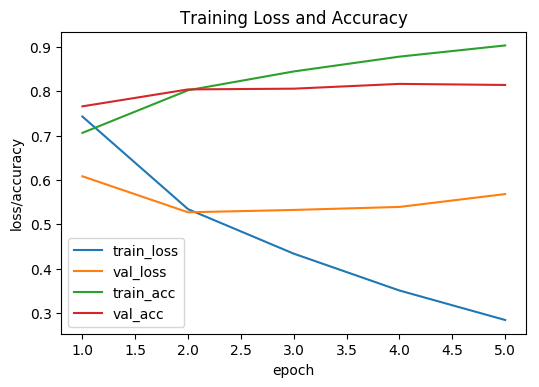

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.figure()
plt.plot(np.arange(0, 5)+1, Model.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5)+1, Model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5)+1, Model.history["acc"], label="train_acc")
plt.plot(np.arange(0, 5)+1, Model.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.legend(loc="lower left")
# plt.savefig('/gdrive/My Drive/glove.6B/plot.png')

In [36]:
score = model.evaluate([x_dev_claim, x_dev_evidence], dev_labels, verbose=1)
print('Test loss : ', score[0])
print('Test accuracy : ', score[1])

5001/5001 [==============================] - 72s 14ms/step
Test loss :  0.9644639645069033
Test accuracy :  0.6962607478563891


In [0]:
model.save_weights('ESIM.h5')
# model.load_weights('/gdrive/My Drive/glove.6B/ESIM.h5')

In [0]:
test_labels= model.predict([x_test_claim, x_test_evidence])

In [39]:
test_labels[0][0],test_labels[0][1],test_labels[0][2]

(0.0033289904, 0.019952858, 0.9767181)

In [40]:
print(len(test_claims))
print(len(test_evidences))
print(len(test_labels))

14997
14997
14997


In [0]:
def label_decoding(label_list):
    result = []
    for values in label_list:
        max_value = max(list(values))
        index = list(values).index(max_value)
        labels = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
        result.append(labels[index])
    return result

In [42]:
decoded_test_labels = label_decoding(test_labels)
print(decoded_test_labels[:5])
print(len(decoded_test_labels))

['NOT ENOUGH INFO', 'NOT ENOUGH INFO', 'SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']
14997


In [0]:
test_result_dic = {}
for i in range(len(test_claims)) :
    test_result_dic[test_claims[i]] = decoded_test_labels[i]

In [ ]:
def title_id_processor(str):
    title = str.split(' ')[0]
    id = str.split(' ')[1]
    return [title, id]

def DumpJSONFile(file):
    result = {}
    with open(file, 'r') as f:
        data = json.load(f)
        for key, value in data.items():
            temp = {}
            evidence_list = []
            print(key)
            temp['claim'] = value['claim']
            if len(value['evidence'])>0:
                print(value['evidence'])
                for evidence in value['evidence']:
                    evidence_list.append(title_id_processor(evidence))
            temp['evidence'] = evidence_list
            result[key] = temp
        f.close()
    return result

In [ ]:
loaded_result = DumpJSONFile(UNLABEL_PATH)
with open('evidence_unlabelled.json', 'w') as f_out:
    json.dump(loaded_result, f_out, indent=2)

In [ ]:
import json

file_path = 'evidence_unlabelled.json'

result = {}
with open(file_path, 'r') as f:
    data = json.load(f)
def result_evidence_processing(evidence):
    result = []
    for temp in evidence:
        result.append([temp[0], int(temp[1])])
    return result

In [0]:
result = {}
for key, value in data.items():
    temp = {}
    temp['claim'] = value['claim']
    evidence = result_evidence_processing(value['evidence'])
    temp['label'] = test_result_dic[temp['claim']]
    temp['evidence'] = evidence
    result[key] = temp

with open('testoutput.json', 'w') as f_out:
    json.dump(result, f_out, indent=2)